Δ_class

In [2]:
import tensorflow_federated as tff
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import nest_asyncio

nest_asyncio.apply()

# Set the local execution context
tff.backends.native.set_local_execution_context()

# Load and preprocess the MNIST dataset
def preprocess(dataset):
    return dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
mnist_train = (mnist_train[0].reshape(-1, 28, 28), mnist_train[1])
mnist_test = (mnist_test[0].reshape(-1, 28, 28), mnist_test[1])

# Split the data into 10 clients
def create_client_data(data, labels, num_clients=10):
    client_data = []
    client_labels = []
    data_per_client = len(data) // num_clients
    for i in range(num_clients):
        client_data.append(data[i * data_per_client:(i + 1) * data_per_client])
        client_labels.append(labels[i * data_per_client:(i + 1) * data_per_client])
    return client_data, client_labels

client_data, client_labels = create_client_data(mnist_train[0], mnist_train[1])

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)
    
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Create a simple model
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Create a federated learning process
def model_fn():
    model = create_model()
    return tff.learning.from_keras_model(
        model,
        input_spec=(tf.TensorSpec(shape=[None, 28, 28], dtype=tf.float32),
                    tf.TensorSpec(shape=[None], dtype=tf.int32)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Define the client optimizer function
def client_optimizer_fn():
    return tf.keras.optimizers.Nadam(learning_rate=0.001)

# Define the federated averaging process
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=client_optimizer_fn
)

# Initialize the process
state = iterative_process.initialize()

# Custom function to determine if a model is an outlier using a DBSCAN-like approach
def is_outlier(metric_data, epsilon=0.4, min_samples=3):
    num_points = metric_data.shape[0]
    distances = np.linalg.norm(metric_data[:, np.newaxis] - metric_data, axis=2)
    neighbors = np.sum(distances < epsilon, axis=1)
    outliers = neighbors < min_samples
    return outliers

# Standalone function for preprocessing
def preprocess_fn(x, y):
    return tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)

# Simulate federated training
num_rounds = 2  # Define the number of rounds
num_clients = 10  # Define the number of clients

for round_num in range(1, num_rounds + 1):
    # Create TensorFlow datasets for each client
    federated_data = [
        tf.data.Dataset.from_tensor_slices((client_data[i], client_labels[i]))
        .map(preprocess_fn)
        .batch(20)
        for i in range(num_clients)
    ]
    
    # Perform a round of federated training
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num}, Metrics: {metrics}')
    
    # Get predictions for each client
    predictions = []
    for i in range(num_clients):
        model = create_model()
        learning_rate = 10.0 if i == 0 else 0.001  # Introduce a bug in the first client
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(client_data[i], client_labels[i], epochs=1, verbose=0)
        predictions.append(model.predict(client_data[i]))
    
    # Initialize the metrics matrix
    metrics_matrix = np.zeros((num_clients, 4))
    
    # Calculate the metrics for each pair of clients
    for i in range(num_clients):
        for j in range(i + 1, num_clients):
            Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(predictions[i], predictions[j])
            metrics_matrix[i, 0] += Δ_class
            metrics_matrix[i, 1] += Δ_score
            metrics_matrix[i, 2] += P_KS
            metrics_matrix[i, 3] += P_X2
    
    # Normalize the metrics matrix
    metrics_matrix /= num_clients - 1
    
    # Calculate the distance matrix
    distance_matrix = np.linalg.norm(metrics_matrix[:, np.newaxis] - metrics_matrix, axis=2)
    
    # Print the distance matrix
    print(f"Round {round_num} Distance Matrix:")
    print(distance_matrix)
    
    # Detect outliers using the custom DBSCAN-like function
    outliers = is_outlier(distance_matrix)
    print(f'Round {round_num}, Outliers: {outliers}')


Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.84315), ('loss', 0.57781976)]))])
Round 1 Distance Matrix:
[[    0.         32516.48098537 34038.22491044 39680.4895935
  40924.60380177 46010.488301   49297.26543936 53179.54977268
  56542.46110199 60231.67936875]
 [32516.48098537     0.          1628.40650062  7228.79097037
   8538.29363949 13617.68482934 16925.13146126 20817.83760518
  24196.66041341 27896.22158629]
 [34038.22491044  1628.40650062     0.          5652.96349885
   6941.03909763 12030.67745648 15336.88027997 19230.64509207
  22608.7333504  26308.50387613]
 [39680.4895935   7228.79097037  5652.96349885     0.
   1363.31732779  6390.09956843  9697.40879114 13589.41211196
  16968.27010797 20667.6858782 ]
 [40924.60380177  8538.29363949  6941.03909763  1363.31732779
      0.          5094.01149378  8397.54473356 12291.20675885
  15

In [12]:
import tensorflow_federated as tff
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import nest_asyncio

nest_asyncio.apply()

# Set the local execution context
tff.backends.native.set_local_execution_context()

# Load and preprocess the MNIST dataset
def preprocess(dataset):
    return dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
mnist_train = (mnist_train[0].reshape(-1, 28, 28), mnist_train[1])
mnist_test = (mnist_test[0].reshape(-1, 28, 28), mnist_test[1])

# Split the data into 10 clients
def create_client_data(data, labels, num_clients=10):
    client_data = []
    client_labels = []
    data_per_client = len(data) // num_clients
    for i in range(num_clients):
        client_data.append(data[i * data_per_client:(i + 1) * data_per_client])
        client_labels.append(labels[i * data_per_client:(i + 1) * data_per_client])
    return client_data, client_labels

client_data, client_labels = create_client_data(mnist_train[0], mnist_train[1])

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)

    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)

    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Create a simple model
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Create a federated learning process
def model_fn():
    model = create_model()
    return tff.learning.from_keras_model(
        model,
        input_spec=(tf.TensorSpec(shape=[None, 28, 28], dtype=tf.float32),
                    tf.TensorSpec(shape=[None], dtype=tf.int32)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Define the client optimizer function
def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the federated averaging process
iterative_process = tff.learning.build_federated_averaging_process(model_fn, client_optimizer_fn=client_optimizer_fn)
state = iterative_process.initialize()

# Custom function to determine if a model is an outlier using a DBSCAN-like approach
def is_outlier(metric_data, epsilon=0.4, min_samples=3):
    num_points = metric_data.shape[0]
    distances = np.linalg.norm(metric_data[:, np.newaxis] - metric_data, axis=2)
    neighbors = np.sum(distances < epsilon, axis=1)
    outliers = neighbors < min_samples
    return outliers

# Standalone function for preprocessing
def preprocess_fn(x, y):
    return tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)

# Simulate federated training
num_rounds = 2
num_clients = 10

for round_num in range(1, num_rounds + 1):
    federated_data = [
        tf.data.Dataset.from_tensor_slices((client_data[i], client_labels[i])).map(preprocess_fn).batch(20)
        for i in range(num_clients)
    ]
    
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num}, Metrics: {metrics}')
    
    predictions = []
    for i in range(num_clients):
        model = create_model()
        learning_rate = 10.0 if i == 0 else 0.001  # Introduce a bug in the first client
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
        model.fit(client_data[i], client_labels[i], epochs=1, verbose=0)
        predictions.append(model.predict(client_data[i]))
    
    metrics_matrix = np.zeros((num_clients, 4))
    
    for i in range(num_clients):
        for j in range(i + 1, num_clients):
            Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(predictions[i], predictions[j])
            metrics_matrix[i, 0] += Δ_class
            metrics_matrix[i, 1] += Δ_score
            metrics_matrix[i, 2] += P_KS
            metrics_matrix[i, 3] += P_X2
            
    metrics_matrix /= num_clients - 1
    
    distance_matrix = np.linalg.norm(metrics_matrix[:, np.newaxis] - metrics_matrix, axis=2)
    print(f"Round {round_num} Distance Matrix:")
    print(distance_matrix)

    # Detect initial outliers using the custom DBSCAN-like function
    initial_outliers = is_outlier(distance_matrix)
    print(f'Round {round_num}, Initial Outliers: {initial_outliers}')

    # Loop to determine the best epsilon and min_samples
    best_params = {'epsilon': None, 'min_samples': None, 'success': False}

    # Define ranges for epsilon and min_samples
    epsilons = np.arange(0.1, 5.0, 0.1)  # Adjust range and step as necessary
    min_samples_list = range(1, 6)  # Adjust this range to test various neighbor criteria

    for epsilon in epsilons:
        for min_samples in min_samples_list:
            outliers = is_outlier(distance_matrix, epsilon=epsilon, min_samples=min_samples)
            # Check if the first client is flagged, and no other clients are flagged
            first_client_outlier = outliers[0]
            other_clients_outliers = np.any(outliers[1:])
            
            if first_client_outlier and not other_clients_outliers:
                best_params['epsilon'] = epsilon
                best_params['min_samples'] = min_samples
                best_params['success'] = True
                break  # Exit the inner loop if we found a successful configuration

        if best_params['success']:
            break  # Exit the outer loop if we've found parameters

    if best_params['success']:
        print(f"Best Parameters Found: Epsilon: {best_params['epsilon']}, Min Samples: {best_params['min_samples']}")
    else:
        print("No suitable parameters found to identify the first client.")

Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.83208334), ('loss', 0.59366876)]))])
Round 1 Distance Matrix:
[[    0.         34040.55745812 33711.02318663 39034.25042463
  42685.93373866 45819.79317926 48609.83984972 53181.74959316
  56702.27350333 60122.21681852]
 [34040.55745812     0.           701.84480875  5096.77026896
   8767.68167802 11928.31798333 14747.1072841  19314.25368163
  22849.08996125 26281.49328724]
 [33711.02318663   701.84480875     0.          5334.8101708
   9006.89882564 12163.45165522 14977.36038    19553.10342565
  23087.55648668 26519.64916784]
 [39034.25042463  5096.77026896  5334.8101708      0.
   3675.84301445  6836.127679    9653.82045817 14225.5454763
  17760.61926091 21193.17576377]
 [42685.93373866  8767.68167802  9006.89882564  3675.84301445
      0.          3160.85240556  5979.44792596 10549.71680704
  

Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8306), ('loss', 0.60163194)]))])
Round 1 Distance Matrix:
[[    0.         15835.05526534 20868.96851709 22141.11614525
  29715.3394482  34444.78297778 36316.40035966 41428.84467843
  44986.24361545 48284.07940844]
 [15835.05526534     0.          5046.88674113  6357.38884205
  13912.62344047 18646.55023767 20535.59759581 25646.92534219
  29210.76564499 32515.34880393]
 [20868.96851709  5046.88674113     0.          1366.13550654
   8866.2256049  13600.03745321 15491.30139261 20601.53845627
  24165.84490421 27471.02241866]
 [22141.11614525  6357.38884205  1366.13550654     0.
   7574.24155562 12305.22756373 14185.68708051 19298.58817195
  22860.80011413 26163.92537059]
 [29715.3394482  13912.62344047  8866.2256049   7574.24155562
      0.          4733.94081313  6628.99862365 11736.05512511
  15

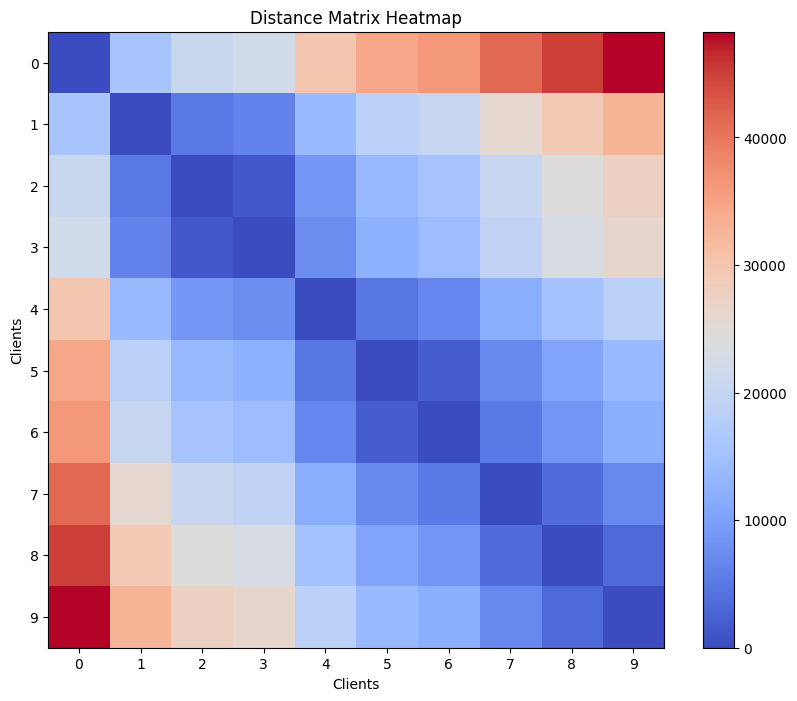

Round 1, Initial Outliers: [ True  True  True  True  True  True  True  True  True  True]
No suitable parameters found to identify the first client.
Round 2, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.90788335), ('loss', 0.31387976)]))])
Round 2 Distance Matrix:
[[    0.         20697.62562314 25945.4205684  27531.59802178
  31096.5033192  34010.27022614 37179.32350257 40551.75131682
  44721.72352233 47819.97630336]
 [20697.62562314     0.          5263.92338523  6887.82998114
  10470.91624012 13406.2710257  16590.07888682 19972.53825167
  24143.72611109 27252.33844086]
 [25945.4205684   5263.92338523     0.          1659.44623148
   5223.73875035  8160.1057736  11342.81625546 14723.69817836
  18891.46079525 22000.55037304]
 [27531.59802178  6887.82998114  1659.44623148     0.
   3583.08817914  6518.82077201  9702.72979364 13085.06643584
  17255.9

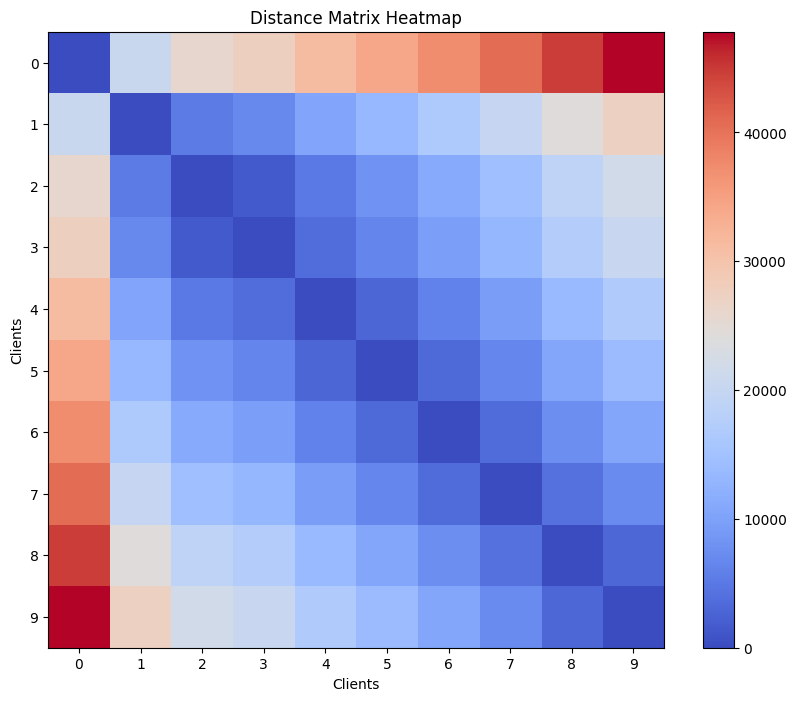

Round 2, Initial Outliers: [ True  True  True  True  True  True  True  True  True  True]
No suitable parameters found to identify the first client.


In [18]:
import tensorflow_federated as tff
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import nest_asyncio
import matplotlib.pyplot as plt
from collections import OrderedDict

nest_asyncio.apply()

# Set the local execution context
tff.backends.native.set_local_execution_context()

# Load and preprocess the MNIST dataset
def preprocess(dataset):
    return dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
mnist_train = (mnist_train[0].reshape(-1, 28, 28), mnist_train[1])
mnist_test = (mnist_test[0].reshape(-1, 28, 28), mnist_test[1])

# Split the data into 10 clients
def create_client_data(data, labels, num_clients=10):
    client_data = []
    client_labels = []
    data_per_client = len(data) // num_clients
    for i in range(num_clients):
        client_data.append(data[i * data_per_client:(i + 1) * data_per_client])
        client_labels.append(labels[i * data_per_client:(i + 1) * data_per_client])
    return client_data, client_labels

client_data, client_labels = create_client_data(mnist_train[0], mnist_train[1])

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)

    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)

    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Create a simple model
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Create a federated learning process
def model_fn():
    model = create_model()
    return tff.learning.from_keras_model(
        model,
        input_spec=(tf.TensorSpec(shape=[None, 28, 28], dtype=tf.float32),
                    tf.TensorSpec(shape=[None], dtype=tf.int32)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Define the client optimizer function
def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the federated averaging process
iterative_process = tff.learning.build_federated_averaging_process(model_fn, client_optimizer_fn=client_optimizer_fn)
state = iterative_process.initialize()

# Custom function to determine if a model is an outlier using a DBSCAN-like approach
def is_outlier(metric_data, epsilon=0.4, min_samples=3):
    num_points = metric_data.shape[0]
    distances = np.linalg.norm(metric_data[:, np.newaxis] - metric_data, axis=2)
    neighbors = np.sum(distances < epsilon, axis=1)
    outliers = neighbors < min_samples
    return outliers

# Visualization function for the distance matrix
def visualize_distance_matrix(distance_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title("Distance Matrix Heatmap")
    plt.xlabel("Clients")
    plt.ylabel("Clients")
    plt.xticks(np.arange(distance_matrix.shape[0]))
    plt.yticks(np.arange(distance_matrix.shape[0]))
    plt.show()

# Standalone function for preprocessing
def preprocess_fn(x, y):
    return tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)

# Simulate federated training
num_rounds = 2
num_clients = 10

for round_num in range(1, num_rounds + 1):
    federated_data = [
        tf.data.Dataset.from_tensor_slices((client_data[i], client_labels[i])).map(preprocess_fn).batch(20)
        for i in range(num_clients)
    ]
    
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num}, Metrics: {metrics}')
    
    predictions = []
    for i in range(num_clients):
        model = create_model()
        learning_rate = 100.0 if i == 0 else 0.001  # Introduce a bug in the first client
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
        model.fit(client_data[i], client_labels[i], epochs=1, verbose=0)
        predictions.append(model.predict(client_data[i]))

    metrics_matrix = np.zeros((num_clients, 4))

    for i in range(num_clients):
        for j in range(i + 1, num_clients):
            Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(predictions[i], predictions[j])
            metrics_matrix[i, 0] += Δ_class
            metrics_matrix[i, 1] += Δ_score
            metrics_matrix[i, 2] += P_KS
            metrics_matrix[i, 3] += P_X2
            
    metrics_matrix /= num_clients - 1
    
    distance_matrix = np.linalg.norm(metrics_matrix[:, np.newaxis] - metrics_matrix, axis=2)
    print(f"Round {round_num} Distance Matrix:")
    print(distance_matrix)
    
    # Visualize the distance matrix
    visualize_distance_matrix(distance_matrix)

    # Detect initial outliers using the custom DBSCAN-like function
    initial_outliers = is_outlier(distance_matrix)
    print(f'Round {round_num}, Initial Outliers: {initial_outliers}')

    # Loop to determine the best epsilon and min_samples
    best_params = {'epsilon': None, 'min_samples': None, 'success': False}

    # Define ranges for epsilon and min_samples
    epsilons = np.arange(0.1, 5.0, 0.05)  # Smaller step for better granularity
    min_samples_list = range(1, 10)  # Wider range for neighbor counts

    for epsilon in epsilons:
        for min_samples in min_samples_list:
            outliers = is_outlier(distance_matrix, epsilon=epsilon, min_samples=min_samples)
            first_client_outlier = outliers[0]
            other_clients_outliers = np.any(outliers[1:])

            if first_client_outlier and not other_clients_outliers:
                best_params['epsilon'] = epsilon
                best_params['min_samples'] = min_samples
                best_params['success'] = True
                break  # Exit the inner loop if we found a successful configuration

        if best_params['success']:
            break  # Exit the outer loop if we've found parameters

    if best_params['success']:
        print(f"Best Parameters Found: Epsilon: {best_params['epsilon']}, Min Samples: {best_params['min_samples']}")
    else:
        print("No suitable parameters found to identify the first client.")
